<a href="https://colab.research.google.com/github/Dhanunjaikumar369/AgenticAI/blob/main/Agentic_AI_Data_Visulization_PipeLine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install autogenstudio
# !pip install autogen-agentchat autogen-ext-genai

# !pip install autogen_ext_genai



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.1/106.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.9/296.9 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.3/289.3 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.7/202.7 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

--- Cleaning Stage ---
    age        income  purchase_count  income_per_purchase  age_squared
0  25.0  50000.000000             5.0         9.999998e+03        625.0
1  25.0  60000.000000             7.0         8.571427e+03        625.0
2  30.0  52666.666667             3.0         1.755555e+04        900.0
3  22.0  48000.000000             0.0         4.800000e+10        484.0
--- Analysis Stage ---
    age        income  purchase_count  income_per_purchase  age_squared  \
0  25.0  50000.000000             5.0         9.999998e+03        625.0   
1  25.0  60000.000000             7.0         8.571427e+03        625.0   
2  30.0  52666.666667             3.0         1.755555e+04        900.0   
3  22.0  48000.000000             0.0         4.800000e+10        484.0   

  income_bracket  purchase_frequency    age_group  spending_score  \
0            Low                0.20  Young Adult        250000.0   
1         Medium                0.28  Young Adult        420000.0   
2         M

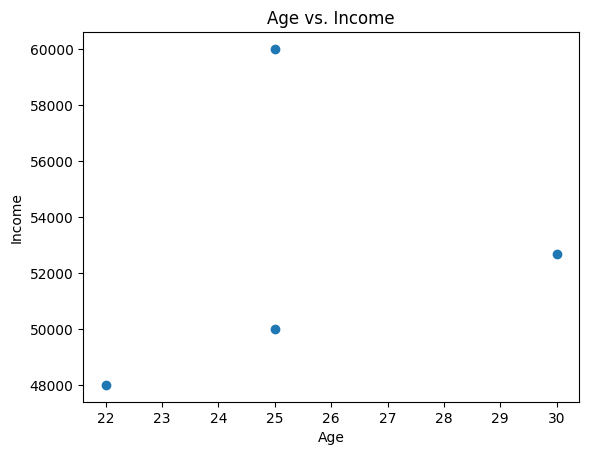

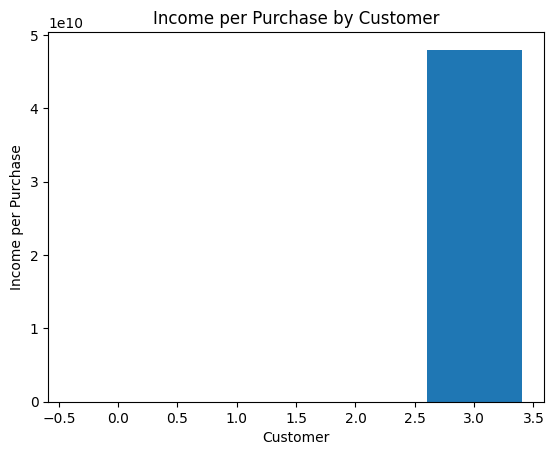

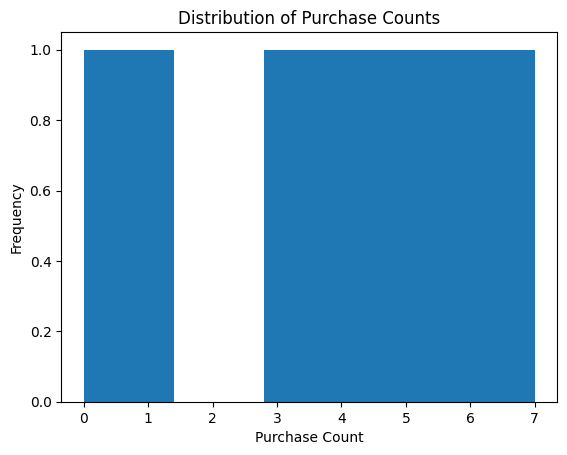

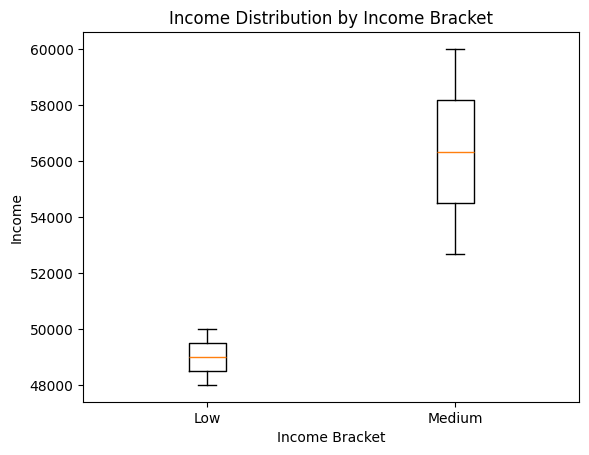

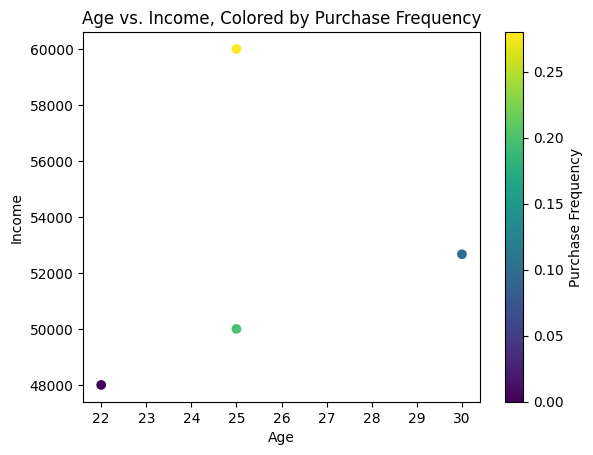

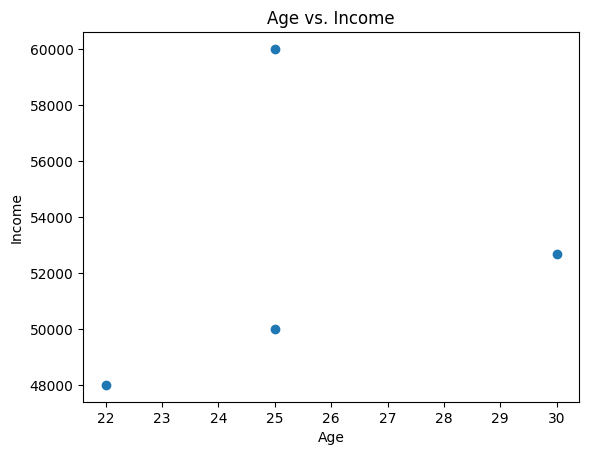

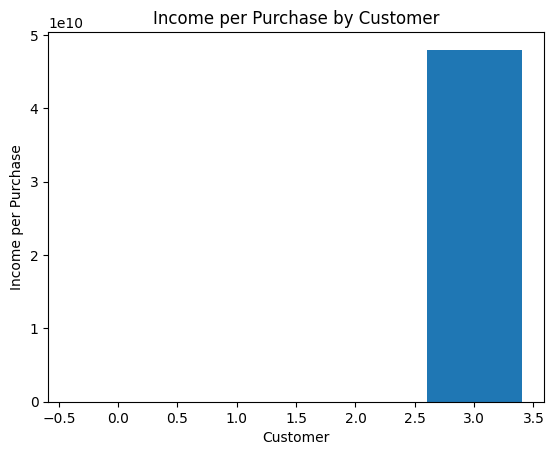

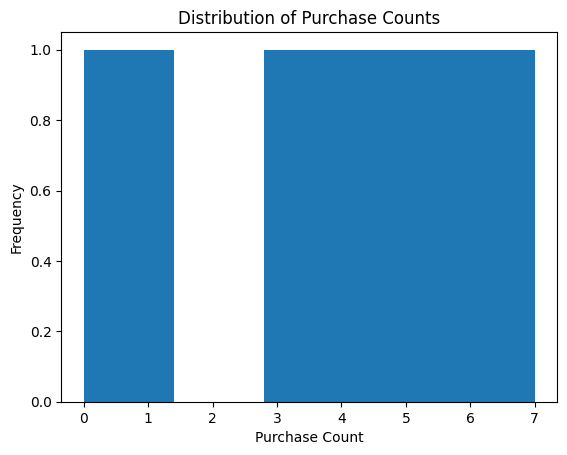

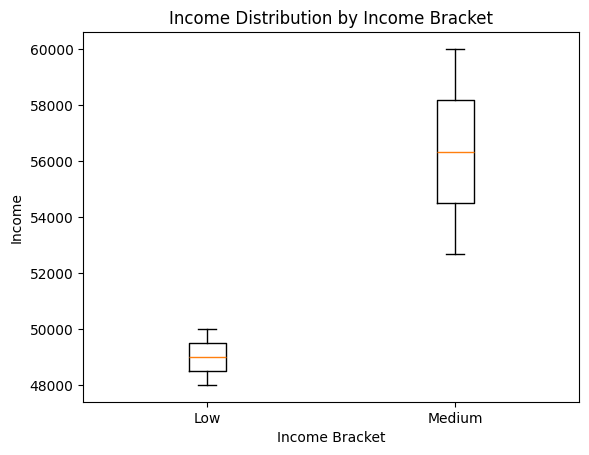

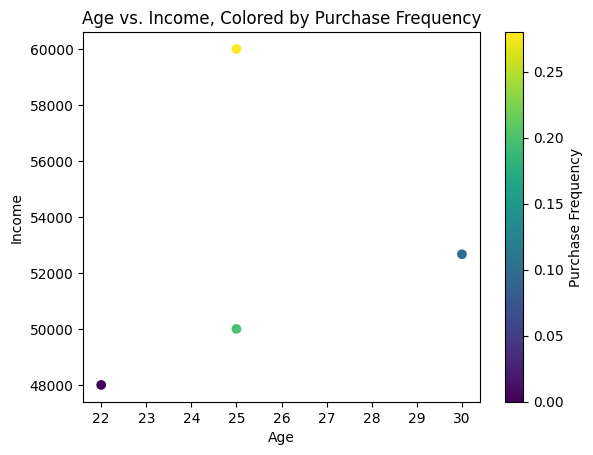

In [6]:
#!/usr/bin/env python3
# practice_autogen_agentchat_workflow.py

import os
import datetime
import asyncio
import nest_asyncio
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import traceback
from google.colab import userdata

# Allow asyncio.run() inside Colab/Jupyter
nest_asyncio.apply()

from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.messages import TextMessage
from autogen_core import CancellationToken
from autogen_ext.models.openai import OpenAIChatCompletionClient

# Helper to extract text from agent response
def extract_content(resp):
    try:
        return resp.chat_message.content
    except AttributeError:
        return resp.content

# Helper to strip markdown fences from code strings
def strip_fences(code_str: str) -> str:
    code_str = re.sub(r"^```(?:python)?\s*", "", code_str)
    code_str = re.sub(r"\s*```$", "", code_str)
    return code_str

async def main():
    start_time = datetime.datetime.now()

    api_key = userdata.get("GENAI_API_KEY")
    if not api_key:
        raise RuntimeError("Please set GENAI_API_KEY via Colab Secrets")

    model_client = OpenAIChatCompletionClient(
        model="gemini-2.0-flash",
        api_key=api_key,
        temperature=0.0,
    )
    token = CancellationToken()

    # Original raw data
    raw_data = {
        "age": [25, None, 30, 22],
        "income": [50000, 60000, None, 48000],
        "purchase_count": [5, 7, 3, None]
    }

    # Define agents
    cleaner = AssistantAgent(
        name="DataCleaningAgent",
        system_message=(
            "You are a data-cleaning expert."
            "Write a Python function `def clean_data(df):` that takes a pandas DataFrame `df` as input, impute missing values, and create new features."
            "Do NOT include any print statements or markdown fences."
            "At the end of your response, call `clean_data(df)` and return the resulting DataFrame object."
        ),
        model_client=model_client,
    )
    analyzer = AssistantAgent(
        name="DataAnalysisAgent",
        system_message=(
            "You are a data-analysis expert. "
            "Create some additional features (KPI's) that could be useful for visualizations and return the df. Don't print anything. "
            "Do NOT include any print statements or markdown fences."
            "At the end of your response, call the created function and return the resulting DataFrame object."
        ),
        model_client=model_client,
    )
    viz = AssistantAgent(
        name="VisualizationAgent",
        system_message=(
            "You are a visualization expert. "
            "Generate Python/matplotlib code snippets and brief descriptions "
            "for plots that illustrate key patterns in the data. Don't print anything. "
            "Generate just the code, nothing else."
        ),
        model_client=model_client,
    )
    code_cleaner = AssistantAgent(
        name="CodeCleaningAgent",
        system_message=(
            "You are a code-cleaning expert. Remove any non-executable symbols or extraneous text from code snippets. "
            "Wrap logic in a function if missing, ensure it returns the modified DataFrame or figures as applicable, and do NOT include print statements or markdown fences. "
            "At the end of your response, call that function with the appropriate variable and return the result."
        ),
        model_client=model_client,
    )
    error_corrector = AssistantAgent(
        name="ErrorCorrectionAgent",
        system_message=(
            "You are a code error-correction expert. Given a Python code snippet and an exception traceback, fix the code so it runs without error. "
            "Return only corrected executable code, without markdown fences or prints."
        ),
        model_client=model_client,
    )

    df = None
    data_input = raw_data

    # Pipeline stages
    stages = [
        ("Cleaning", cleaner),
        ("Analysis", analyzer),
        ("Visualization", viz)
    ]

    for name, agent in stages:
        print(f"--- {name} Stage ---")

        # 1. Generate code
        resp = await agent.on_messages([TextMessage(content=str(data_input), source="user")], token)
        code = extract_content(resp)

        attempt = 0
        while True:
            attempt += 1
            # 2. Clean code after code_cleaner
            clean_resp = await code_cleaner.on_messages([TextMessage(content=code, source="user")], token)
            raw_clean = extract_content(clean_resp)
            clean_code = strip_fences(raw_clean)
            #print("Cleaned Code:\n", clean_code)

            try:
                # 3. Execute
                exec_df = df if (name == "Visualization" and df is not None) else data_input
                if not isinstance(exec_df, pd.DataFrame):
                    exec_df = pd.DataFrame(exec_df)
                local_ctx = {'pd': pd, 'np': np, 'df': exec_df}
                exec(clean_code, local_ctx, local_ctx)
                result = local_ctx.get('df', local_ctx.get('result'))
                figures = local_ctx.get('figures', None)
                break
            except Exception:
                tb = traceback.format_exc()
                print("Error Traceback:\n", tb)
                err_msg = f"Code:\n{clean_code}\nException:\n{tb}"
                err_resp = await error_corrector.on_messages([TextMessage(content=err_msg, source="user")], token)
                code = extract_content(err_resp)
                #print("Corrected Code:\n", code)
                if attempt >= 2:
                    raise RuntimeError("Failed to correct code after multiple attempts")

        # 4. Handle outputs
        if name in ("Cleaning", "Analysis"):
            df = result
            print(df)
            data_input = df.to_dict(orient='list')
        else:
            if figures:
                for fig in figures:
                    fig.show()
            else:
                exec(clean_code, {'pd': pd, 'np': np, 'df': df, 'plt': plt}, {})

    duration = datetime.datetime.now() - start_time
    print(f"\nTotal elapsed time: {duration}")

    await model_client.close()

if __name__ == "__main__":
    asyncio.run(main())
